In [59]:
import pandas as pd
import numpy as np
from collections import Counter
import math

In [60]:
df = pd.read_csv('../data/spatial_merged_solid.csv', encoding='latin-1')
topics = pd.read_csv('../data/topic_output.csv', index_col=[0], encoding='latin-1')
complaint = pd.read_csv('../data/311_complaint.csv', encoding='latin-1')
insp = pd.read_csv('../data/clean_bz.csv', encoding='latin-1')

In [61]:
# merge original inspection stuff with main df
df = df.merge(insp, on='CAMIS', how='left')

In [62]:
# merge 311 stuff with main df
df = df.merge(complaint, on='CAMIS', how='left')

In [63]:
# feature selection
df = df.loc[:, ['CAMIS', # inspection data
                'new_grade',
                'INSPECTION DATE_y',
                'VIOLATION CODE',
                'SCORE',
                'GRADE_y',
                'CD', # pluto data, BBL-level (spatially merged)
                'HealthArea',
                'SanitDistr',
                'AssessTot',
                'YearAlter1',
                'YearAlter2',
                'YearBuilt',
                'NumFloors',
                'yelp_rating', # yelp data, restaurant-level
                'yelp_categories',
                'yelp_review_count',
                'stats.checkinsCount', # foursquare data, restaurant-level
                'stats.tipCount',
                'stats.usersCount',
                '311_complaint_count', # 311 food complaints, restaurant-level
                'goog_lat', # google location
                'goog_lng']]

In [64]:
# rename a couple weird columns post-merge
df.columns =   ['CAMIS', # inspection data
                'new_grade',
                'INSPECTION DATE',
                'VIOLATION CODE',
                'SCORE',
                'GRADE',
                'CD', # pluto data, BBL-level (spatially merged)
                'HealthArea',
                'SanitDistr',
                'AssessTot',
                'YearAlter1',
                'YearAlter2',
                'YearBuilt',
                'NumFloors',
                'yelp_rating', # yelp data, restaurant-level
                'yelp_categories',
                'yelp_review_count',
                'stats.checkinsCount', # foursquare data, restaurant-level
                'stats.tipCount',
                'stats.usersCount',
                '311_complaint_count', # 311 food complaints, restaurant-level
                'goog_lat', # google location
                'goog_lng']

In [65]:
df = df.merge(topics, on='CAMIS', how='left')

In [66]:
# from collections import defaultdict
# d = defaultdict(LabelEncoder)

# # Encoding the variable
# fit = df_drop.apply(lambda x: d[x.name].fit_transform(x))
# features = fit.drop(["SCORE", "GRADE","new_grade"], 1)
# target = fit["SCORE"]

# # Inverse the encoded
# # fit.apply(lambda x: d[x.name].inverse_transform(x))

# # Using the dictionary to label future data
# #df.apply(lambda x: d[x.name].transform(x))

In [67]:
# only care about the records with a y-label (either A, B, or C)
df.GRADE = df.GRADE.apply(str)
df = df.loc[df.GRADE.isin(['A', 'B', 'C']), :]

In [68]:
# fill NA on 311 column
df.loc[:, '311_complaint_count'] = df.loc[:, '311_complaint_count'].fillna(0)

In [69]:
def clean_cat(cat):
    """
    cleans a single yelp category string
    """
    cat = cat.replace('[', '')\
    .replace(']', '')\
    .replace('u', '')\
    .replace("'", "")\
    .replace(" ", "")
    
    return cat

In [70]:
def get_top_categories(n):
    """
    returns a list of top n yelp categories from observed data
    """
    yelp_cats = list(df.yelp_categories)
    yelp_cats = filter(lambda cat: type(cat)==str, yelp_cats)
    yelp_cats = ','.join(yelp_cats).split(',')
    yelp_cats = map(clean_cat, yelp_cats)
    
    return map(lambda x: x[0], Counter(yelp_cats).most_common(n))

In [71]:
def substring(cat, cats):
    """
    checks if a string contains a substring, with error handling
    """
    try:
        return int(cat in cats)
    except TypeError:
        return 0

In [72]:
def category_one_hot(df, n):
    """
    appends 'n' columns to a dataframe
    corresponding to yes/no for the 'n' most common yelp categories
    """
    for cat in get_top_categories(n):
        col_name = 'is_' + cat
        df.loc[:, col_name] = df.apply(lambda row: substring(cat, row['yelp_categories']), axis=1)
    return df

In [73]:
# SET NUMBER OF FOOD CATEGORIES HERE
food_num = 20

In [74]:
# append cuisine category one-hots to dataframe
df = category_one_hot(df, food_num)
df.head()

,CAMIS,new_grade,INSPECTION DATE,VIOLATION CODE,SCORE,GRADE,CD,HealthArea,SanitDistr,AssessTot,...,is_tradamerican,is_bars,is_mexican,is_donts,is_cafes,is_salad,is_japanese,is_desserts,is_seafood,is_icecream
225,50060711,A,03/22/2017,10H,7.0,A,107.0,3500.0,7.0,2049750.0,...,0,0,0,0,0,0,0,0,0,0
259,50060463,A,03/02/2017,06F,13.0,A,310.0,7820.0,10.0,141750.0,...,0,0,0,0,0,0,0,0,0,0
266,50060418,A,03/22/2017,06C,9.0,A,106.0,5000.0,6.0,15238350.0,...,0,0,0,0,0,0,0,0,0,0
270,50060396,A,03/06/2017,10F,7.0,A,414.0,3700.0,14.0,329850.0,...,0,0,0,0,0,0,0,0,0,0
276,50060377,A,03/23/2017,04L,13.0,A,401.0,400.0,1.0,27216.0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
def create_y(row):
    """
    output label: 1 for bad inspection, 0 for normal
    """
    if row['GRADE'] in ['B', 'C']:
        return 1
    else:
        return 0

In [76]:
# create the final label variable
df.loc[:, 'failed'] = df.apply(create_y, axis=1)

In [77]:
df.groupby('failed').size()

failed
0    8078
1     846
dtype: int64

In [78]:
# years since renovation
def get_yrs_since_reno(row):
    last_reno = max(row['YearAlter1'], row['YearAlter2'])
    if last_reno == 0:
        return 2017 - row['YearBuilt']
    else:
        return 2017 - last_reno

In [79]:
# years since renovation
df.loc[:, 'yrs_since_reno'] = df.apply(get_yrs_since_reno, axis=1)

In [80]:
# building age
df.loc[:, 'bldg_age'] = df.apply(lambda row: 2017 - row['YearBuilt'], axis=1)

In [81]:
#numerics = [ u'AssessTot', u'NumFloors', u'yelp_rating', u'yelp_review_count',
#       u'stats.checkinsCount', u'stats.tipCount', u'stats.usersCount',
#       u'311_complaint_count', u'yrs_since_reno', u'bldg_age']

numerics = [u'yelp_rating', u'yelp_review_count',
       u'stats.checkinsCount', u'stats.tipCount', u'stats.usersCount',
       u'311_complaint_count', u'yrs_since_reno', u'bldg_age']

In [82]:
#categoricals = [u'CD', u'HealthArea', u'SanitDistr'] + \
#    map(lambda cuisine: 'is_' + cuisine, get_top_categories(food_num))
    
categoricals = map(lambda cuisine: 'is_' + cuisine, get_top_categories(food_num))

In [83]:
# standardize numeric columns
for col in numerics:
    vect = df.loc[:, col]
    mean = np.nanmean(vect)
    std = np.nanstd(vect)
    df.loc[:, col] = (vect - mean) / std

In [84]:
# these columns look like numericals, but are actually categorical
# convert to strings (with a prefix), so that scikitlearn algos can treat them as categorical


def stringize(num, prefix):
    if math.isnan(num):
        return np.nan
    else:
        return prefix + '_' + str(int(num))

for col in [u'CD', u'HealthArea', u'SanitDistr']:
    df.loc[:, col] = list(map(lambda val: stringize(val, col), df.loc[:, col]))

In [85]:
df[df.select_dtypes(exclude=['float64']).columns] = df[df.select_dtypes(exclude=['float64']).columns].fillna('NAN')

In [86]:
# fill missing FS and yelp data with zeroes
df = df.fillna(0)

In [87]:
import seaborn as sns
sns.set()

In [88]:
def scale_log(x):
    return(np.log(x+1))

In [ ]:
# Show the survival proability as a function of age and sex
from scipy.stats import kendalltau
sg = sns.jointplot("y_log", "f_log", data=df2, kind="kde",
                  xlim=(0, 60), ylim=(0, 12), color="r", size=7)

In [ ]:
def map_string(x):
    if x == 1:
        return 'failed'
    else:
        return 'good'

## p_value starts from here

In [137]:
import sklearn.pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

In [122]:
# create X and y from all selected features
X = df[['VIOLATION CODE',
       'HealthArea', 'SanitDistr', 'AssessTot',
       'YearAlter1', 'YearAlter2', 'YearBuilt', 'NumFloors', 'yelp_rating',
       'yelp_review_count', 'stats.checkinsCount',
       'stats.tipCount', 'stats.usersCount', '311_complaint_count',
       'goog_lat', 'goog_lng', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'topic_9', 'yrs_since_reno', 'bldg_age']]
y = df.failed

In [93]:
from collections import defaultdict
from itertools import cycle
d = defaultdict(LabelEncoder)

# Encoding the variable
fit = X.apply(lambda x: d[x.name].fit_transform(x))
features = fit


# Inverse the encoded
#fit.apply(lambda x: d[x.name].inverse_transform(x))

# Using the dictionary to label future data
#df.apply(lambda x: d[x.name].transform(x))

In [284]:
## F-test with ANOVA

F, p_val = f_classif(features, y)

In [285]:
p_value = pd.DataFrame(p_val,index=[fit.apply(lambda x: d[x.name].inverse_transform(x)).columns.values], columns=['p-value'])

In [286]:
sort_p_value = p_value[p_value['p-value']<0.05].sort_values(by='p-value')

In [287]:
clean_p_value = sort_p_value.drop(sort_p_value.index[[0]])

In [308]:
clean_p_value.head(10)

,p-value
AssessTot,2.241174e-20
topic_9,2.688036e-20
NumFloors,1.408888e-17
bldg_age,1.193866e-12
YearBuilt,1.193866e-12
topic_2,2.702458e-11
topic_6,2.406512e-09
topic_1,4.153706e-05
yrs_since_reno,7.670590e-05
topic_7,1.135256e-04


### plot ROC curve for each classifier

In [135]:
def plot_ROC(features, y, clf, kbest='all', output_fig='Random Forest'):
    
    """
    @parameters features: pandas dataframe
    @parameters y: pandas dataframe
    @parameters classifier: sklearn classifier
    @parameters kbest: number of features(int), if you want all => 'all'
    @parameters output_fig: string, filename
    
    
    """
    print (clf)
    
    from scipy import interp
    
    plt.figure(figsize=(10,8))
    # Run classifier with cross-validation and plot ROC curves

    cv = StratifiedKFold(n_splits=6)


    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    lw = 2


    select = sklearn.feature_selection.SelectKBest(k=kbest)
    steps = [('feature_selection', select),
            ('random_forest', clf)]

    pipeline = sklearn.pipeline.Pipeline(steps)

    i = 0
    for (train, test), color in zip(cv.split(features, y), colors):
        probas_ = pipeline.fit(features.iloc[train], y.iloc[train]).predict_proba(features.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
             label='Luck')

    mean_tpr /= cv.get_n_splits(features, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example {}'.format(output_fig))
    plt.legend(loc="lower right")
    filename = '{} ROC curve.png'.format(output_fig)
    plt.savefig(filename, bbox_inches='tight', format='png', dpi=900)
    plt.show()

####  simple test

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


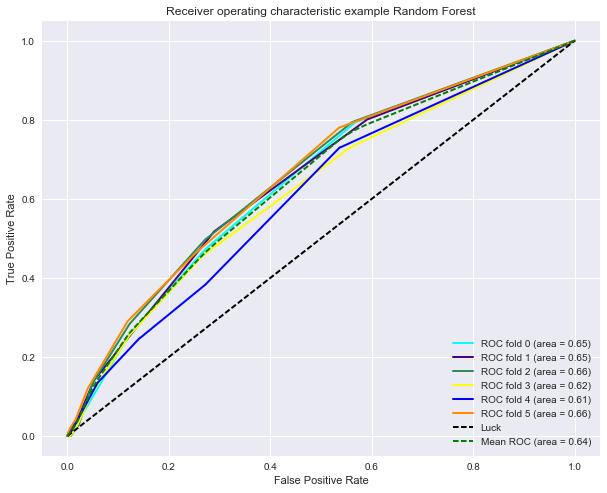

In [136]:
plot_ROC(features, y, RandomForestClassifier(), kbest='all', output_fig='Random Forest')

In [99]:
import pickle
pickle.dump(features, open('../data/x.pkl', 'wb'))
pickle.dump(y, open('../data/y.pkl', 'wb'))

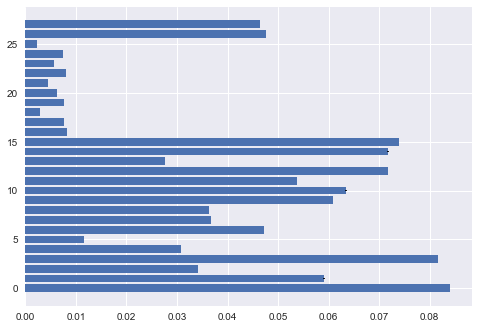

In [102]:
#### plot feature importance for random forest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(features, y)

importance = clf.feature_importances_
predictor = fit.apply(lambda x: d[x.name].inverse_transform(x))
importance = pd.DataFrame(importance, index=predictor.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

x = range(importance.shape[0])
y2 = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.barh(x, y2, yerr=yerr, align="center")

plt.show()

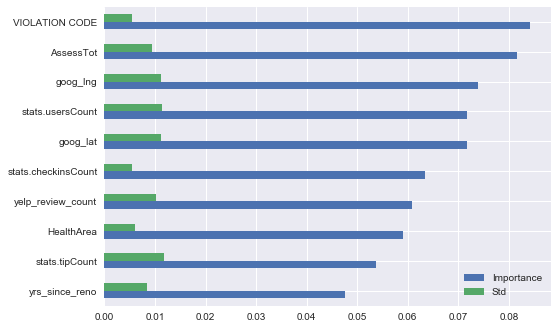

In [105]:
importance.sort_values(by='Importance', ascending=True).tail(10).plot(kind='barh')
p

#### got a better score when I exclude all the (CD, HealthArea, SanitDistr) madness...